In [1]:
#!/home/was966/micromamba/envs/responder/bin/python
#sbatch --mem 64G -c 4 -t 100:00:00 -p gpu_quad --gres=gpu:teslaV100s:1 ./loo_fft_dense16.py

import sys

sys.path.insert(0, '/home/was966/Research/mims-conceptor/')
from conceptor.utils import plot_embed_with_label
from conceptor import PreTrainer, FineTuner, loadconceptor #, get_minmal_epoch
from conceptor.utils import plot_embed_with_label,plot_performance, score2
from conceptor.tokenizer import CANCER_CODE

import os
from tqdm import tqdm
from itertools import chain
import pandas as pd
import numpy as np
import random, torch
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'white', font_scale=1.3)
import warnings
warnings.filterwarnings("ignore")

def onehot(S):
    assert type(S) == pd.Series, 'Input type should be pd.Series'
    dfd = pd.get_dummies(S, dummy_na=True)
    nanidx = dfd[dfd[np.nan].astype(bool)].index
    dfd.loc[nanidx, :] = np.nan
    dfd = dfd.drop(columns=[np.nan])*1.
    cols = dfd.sum().sort_values(ascending=False).index.tolist()
    dfd = dfd[cols]
    return dfd

In [2]:
pretrainer = loadconceptor('../../checkpoint/latest/pretrainer.pt')
data_path = '../../../../paper/00_data/'
df_label = pd.read_pickle(os.path.join(data_path, 'ITRP.PATIENT.TABLE'))
df_tpm = pd.read_pickle(os.path.join(data_path, 'ITRP.TPM.TABLE'))
df_tpm.shape, df_label.shape


dfcx = df_label.cancer_type.map(CANCER_CODE).to_frame('cancer_code').join(df_tpm)

df_task = onehot(df_label.response_label)
size = df_label.groupby('cohort').size()
size = size.index + "\n(n = " + size.astype(str) + ")"
cohorts = df_label.groupby('cohort').size().sort_values().index.tolist()

In [3]:
cohorts = [ 'IMmotion150', 'IMVigor210']

Evaluation on Model PFT


  6%|6         | 6/100 [00:56<14:49,  9.47s/it]

Stopping early at epoch  7. Meet minimal requirements by: f1=0.89,mcc=0.84,prc=0.93, roc=0.96



 23%|##3       | 23/100 [05:43<19:10, 14.94s/it]

Stopping early at epoch 24. Meet minimal requirements by: f1=0.85,mcc=0.81,prc=0.82, roc=0.91



100%|##########| 19/19 [00:01<00:00, 13.90it/s]


0.20029137519297832


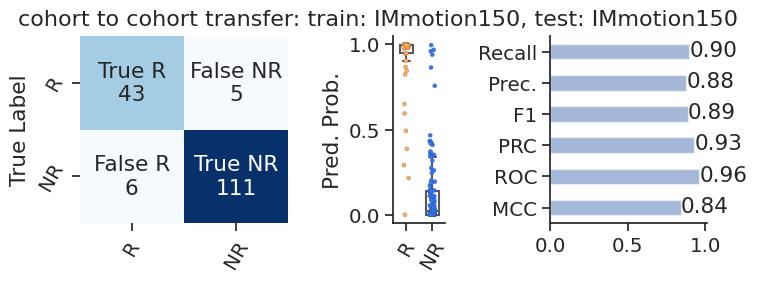

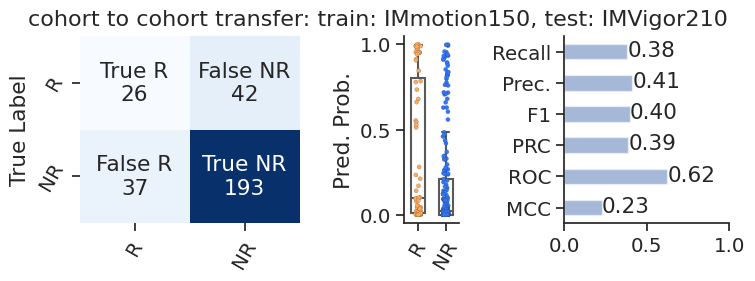

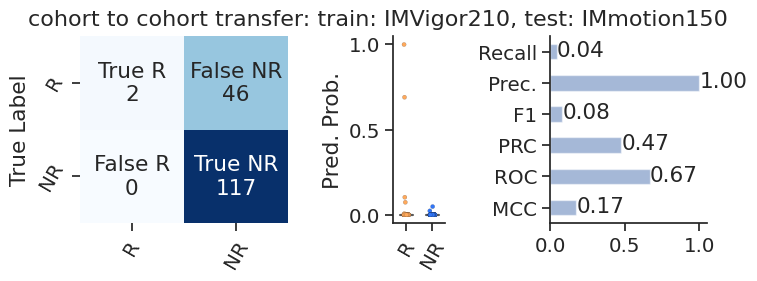

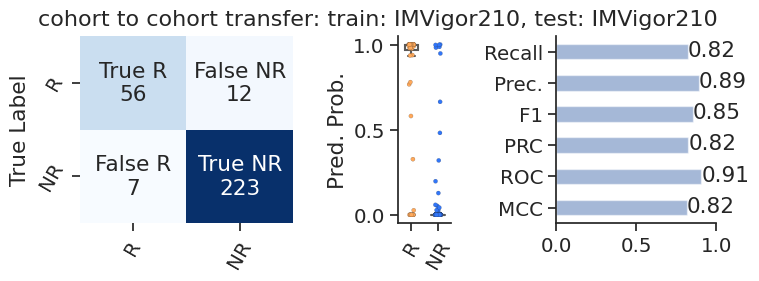

In [20]:
def cohort_to_cohort(cohorts):
    # Create a list of lists, each missing one element from the original list
    return [(cohorts[i], cohorts[:i] + cohorts[i+1:]) for i in range(len(cohorts))]
train_test_cohorts = cohort_to_cohort(cohorts)
res = []

params = {'mode': 'PFT',
            'seed':42,
            'lr': 1e-2,
            'device':'cuda',
            'weight_decay': 1e-4,
            'batch_size':8,
            'max_epochs': 100,
          
            'task_loss_type': 'ce_loss', #focal_loss
            'task_class_weight':[1,2],
            'task_type': 'c',
          
            'load_decoder':False,
            'task_dense_layer': [16],
            'task_batch_norms':True,
            'entropy_weight': 0.0,
            'with_wandb': False,
            'save_best_model':False,
            'verbose': False}

seed = 42
for mode in ['PFT']: #,  ,  'LFT', 'FFT'
    
    print('Evaluation on Model %s' % mode)

    params['mode'] = mode
    params['seed'] = seed
    
    work_dir = './CTCT/CTCT_%s_%s' % (mode, seed)
    if not os.path.exists(work_dir):
        os.makedirs(work_dir)
    
    res = []
    for train_cohort, test_cohorts in train_test_cohorts:
        
        ## Get data for this cohort
        cohort_idx = df_label[df_label['cohort'] == train_cohort].index
        cohort_X = dfcx.loc[cohort_idx]
        cohort_y = df_task.loc[cohort_idx]

        ## Get features for specific method
        train_X = cohort_X
        train_y = cohort_y

        pretrainer = pretrainer.copy()
        finetuner = FineTuner(pretrainer, **params, 
                              work_dir= work_dir, 
                              task_name = '%s' % train_cohort,
                              )
        
        finetuner = finetuner.tune(dfcx_train = train_X,
                                   dfy_train = train_y, 
                                   min_mcc=0.8)

        for test_cohort in cohorts:
            test_cohort_idx = df_label[df_label['cohort'] == test_cohort].index
            test_cohort_X = dfcx.loc[test_cohort_idx]
            test_cohort_y = df_task.loc[test_cohort_idx]

            _, pred_testy = finetuner.predict(test_cohort_X, batch_size = 16)

            pred_testy['train_cohort'] = train_cohort
            pred_testy['test_cohort'] = test_cohort 
            
            pred_testy['best_epoch'] = finetuner.best_epoch
            pred_testy['n_trainable_params'] = finetuner.count_parameters()
            pred_testy['mode'] = mode
            pred_testy['seed'] = seed
            pred_testy['batch_size'] = params['batch_size']
            pred_testy['task_dense_layer'] = str(params['task_dense_layer'])
            dfp = test_cohort_y.join(pred_testy)
    
            y_true, y_prob, y_pred = dfp['R'], dfp[1], dfp[[0, 1]].idxmax(axis=1)
            fig = plot_performance(y_true, y_prob, y_pred)
            fig.suptitle('cohort to cohort transfer: train: %s, test: %s' % (train_cohort, test_cohort), fontsize=16)
            fig.savefig(os.path.join(work_dir, 'CTCT_train_%s_test_%s.jpg' % (train_cohort, test_cohort)))
            res.append(dfp)
    
    dfs = pd.concat(res)
    dfp = dfs.groupby(['train_cohort', 'test_cohort']).apply(lambda x:score2(x['R'], x[1], x[[0, 1]].idxmax(axis=1)))

    #roc, prc, f1, acc, mcc
    dfp = dfp.apply(pd.Series)
    dfp.columns = ['ROC', 'PRC', 'F1', 'ACC', 'MCC']
    dfp = dfp.reset_index()
    
    #dfs.to_csv(os.path.join(work_dir, 'source_performance.tsv'), sep='\t')
    #dfp.to_csv(os.path.join(work_dir, 'metric_performance.tsv'), sep='\t')
    score = dfp[dfp.train_cohort != dfp.test_cohort].MCC.mean()
    # results = {'score':score, 'batch_size':batch_size, 'loss_name':loss_name,  
    #             'class_weights':class_weights, 'task_type':task_type}
    print(score)
    #res.append(results)

In [22]:
score

0.20029137519297832